In [232]:
#! pip install wordcloud

In [317]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
pd.set_option('display.max_colwidth', None)
import nltk
import string
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from wordcloud import WordCloud, ImageColorGenerator
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ngeva\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ngeva\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ngeva\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


read csv

In [241]:
df_neg = pd.read_csv('neg_tweets.csv')
df_pos = pd.read_csv('pos_tweets.csv')

In [283]:
df_neg.shape, df_pos.shape

((1000, 6), (87, 6))

add label column

In [242]:
df_neg['label'] = 'negative'
df_pos['label'] = 'positive'

merge both df

In [243]:
df = df_neg.append(df_pos)
df.reset_index(inplace=True)

In [244]:
df.head()

,index,id,date,username,content,url,label
0,0,1352552131203657729,2021-01-22 09:42:11+00:00,tolloc_maire,@BorisJohnson @CMO_England @uksciencechief #JonathanVanTam The world is waking up &amp; fighting back.\r\n\r\n#WakeUpPeople #COVID19 #Covid19UK #PCRtest \r\n#IDoNotConsent https://t.co/U13WnqETUe,https://twitter.com/tolloc_maire/status/1352552131203657729,negative
1,1,1352544368524218370,2021-01-22 09:11:21+00:00,tolloc_maire,@CMO_England @uksciencechief @BorisJohnson @MattHancock @NHSuk @PHE_uk Yet another scam to keep us in perpetual lockdown. Well #IDoNotConsent keep your £500 &amp; open up the country.\r\n\r\n#Covid19UK #Covid19UK #CovidVaccine https://t.co/RfHvqUbwm1,https://twitter.com/tolloc_maire/status/1352544368524218370,negative
2,2,1352539517614493696,2021-01-22 08:52:04+00:00,lostcreatives1,"@pritipatel rules, not laws. 2-tier policing, violation of human rights, fraud, the Nurenberg code is being violated, the list goes on. you are on thin ice and the trial is coming. #Idonotconsent",https://twitter.com/lostcreatives1/status/1352539517614493696,negative
3,3,1352526249755865090,2021-01-22 07:59:21+00:00,JMichW87,#Polio #PolioMyelitis #PolioVaccine #PolioEradication #DTaP #TDaP #EducateYourSELF #DoYourOWNResearch #MedicalFreedom #InformedConsent #BodyAutonomy #SpeakTruth #ReadTheInsert #IDoNotConsent @justtheinserts https://t.co/oTVX5Q5ETR,https://twitter.com/JMichW87/status/1352526249755865090,negative
4,4,1352506303718039552,2021-01-22 06:40:05+00:00,AliveAwakeReal,Fear\r\nAlways fear\r\nIt’s the governments weapon against us\r\n\r\n#IDoNotConsent https://t.co/qIl6voTZTh,https://twitter.com/AliveAwakeReal/status/1352506303718039552,negative


In [280]:
df.shape

(1087, 11)

date column

In [246]:
df['date'] = df['date'].apply(lambda x: x.split('+')[0])

In [247]:
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)

cleaning content column

In [248]:
df["up_text"] = df.content.str.lower()
#Remove twitter handlers
df.up_text = df.up_text.apply(lambda x:re.sub('@[^\s]+','',x))

#remove hashtags
df.up_text = df.up_text.apply(lambda x:re.sub(r'\B#\S+','',x))

# Remove URLS
df.up_text = df.up_text.apply(lambda x:re.sub(r"http\S+", "", x))

# Remove all the special characters
df.up_text = df.up_text.apply(lambda x:' '.join(re.findall(r'\w+', x)))

#remove all single characters
df.up_text = df.up_text.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))

# Substituting multiple spaces with single space
df.up_text = df.up_text.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))


In [249]:
df['hashtags'] =  df.content.str.lower()
df.hashtags = df.hashtags.apply(lambda x:re.sub('@[^\s]+','',x)) 
df.hashtags = df.hashtags.apply(lambda x:re.sub(r"http\S+", "", x))
df.hashtags = df.hashtags.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))
df.hashtags = df.hashtags.apply(lambda x: x if '#' in x else '')
df.hashtags = df.hashtags.apply(lambda x: [i for i in x.split() if i.startswith('#')])

expand contractions


In [250]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not ","'s":" is ","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
df['up_text']=df['up_text'].apply(lambda x:expand_contractions(x))

In [251]:
for index,text in enumerate(df['up_text'][35:40]):
    print('tweet %d:\n'%(index+1),text)

tweet 1:
 essentially making people your amp did you mention they can no longer donate blood once they take this
tweet 2:
 are we starting to see the hypocrisy yet norms no you want more of their wickedness well
tweet 3:
 itthe 21 1 21 anddonknow who needs to hear it but covid is stillscam
tweet 4:
 whatabsurd is people allowing it
tweet 5:
 


create tokenized column with no stop words 

In [252]:
df['tokenized'] = df['up_text'].apply(word_tokenize)
stop_words = set(stopwords.words('english'))
df['tokenized'] = df['tokenized'].apply(lambda x: [word for word in x if word not in stop_words])
df['pos_tags'] = df['tokenized'].apply(nltk.tag.pos_tag)


In [253]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
df['tokenized'] = df['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

In [254]:
wnl = WordNetLemmatizer()
df['tokenized'] = df['tokenized'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

In [255]:
df.tokenized

0                                                                                                [world, wake, amp, fight, back]
1                                        [yet, another, scam, keep, u, perpetual, lockdown, well, keep, 500, amp, open, country]
2       [rule, law, 2, tier, police, violation, human, right, fraud, nurenberg, code, violate, list, go, thin, ice, trial, come]
3                                                                                                                             []
4                                                                             [fear, always, fear, itthe, government, weapon, u]
                                                                  ...                                                           
1082                                                                 [lincoln, ne, protest, stupid, mandatory, mask, do, silent]
1083                                                                                             

100 top words

In [299]:
words = df['tokenized']
allwords = []
for wordlist in words:
    allwords += wordlist
allwords = [word for word in allwords if word !='amp']

In [300]:
words_neg = df[df['label']=='negative']['tokenized']
allwords_neg = []
for wordlist in words_neg:
    allwords_neg += wordlist
allwords_neg = [word for word in allwords_neg if word !='amp']

words_pos = df[df['label']=='positive']['tokenized']
allwords_pos = []
for wordlist in words_pos:
    allwords_pos += wordlist
words_pos = [word for word in words_pos if word !='amp']

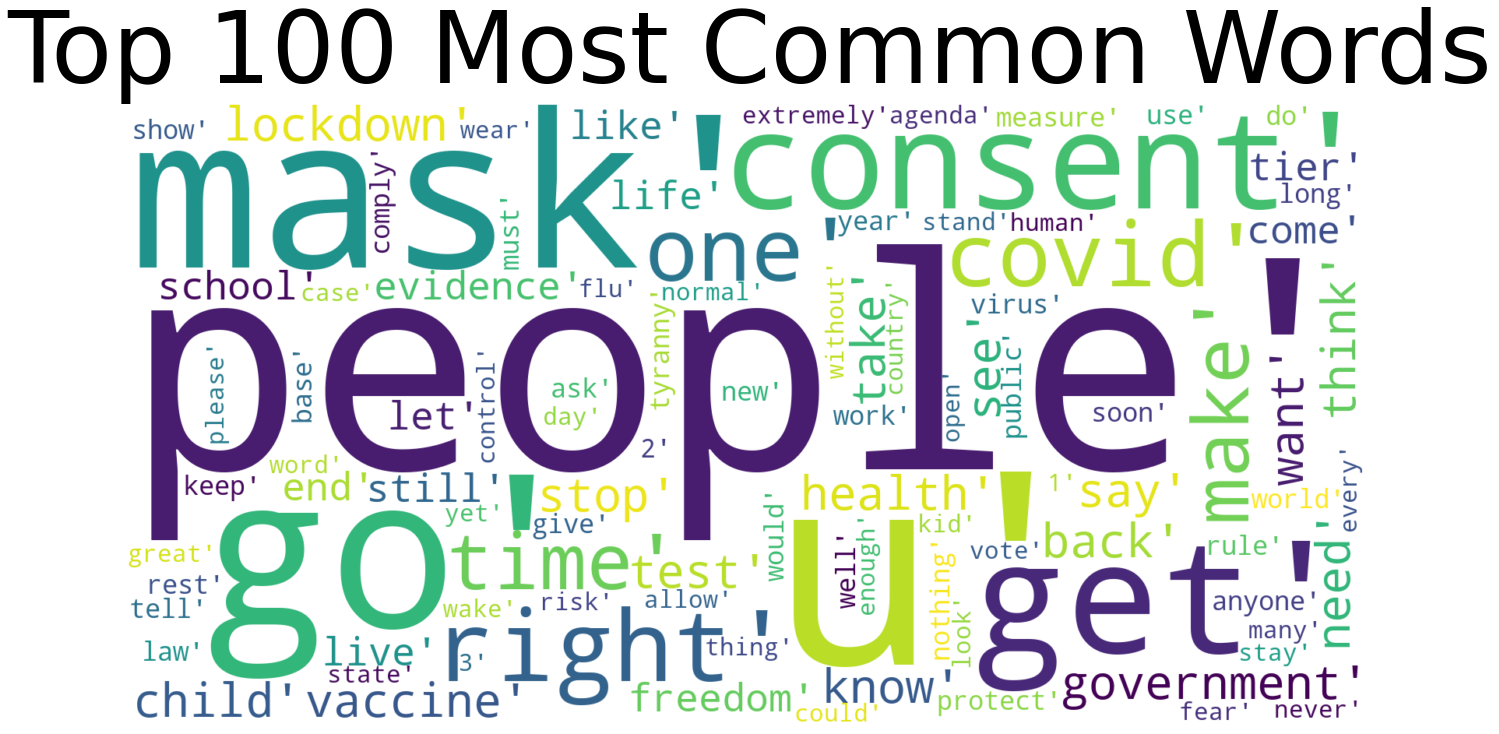

In [301]:
mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))

fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=100)
plt.tight_layout(pad=0)
plt.show()

100 top hashtags

In [308]:
hasht = df['hashtags']
hashtags = []
for wordlist in hasht:
    hashtags += wordlist

hash_neg = df[df['label']=='negative']['hashtags']
hashtags_neg = []
for wordlist in hash_neg:
    hashtags_neg += wordlist

hash_pos = df[df['label']=='positive']['hashtags']
hashtags_pos = []
for wordlist in hash_pos:
    hashtags_pos += wordlist

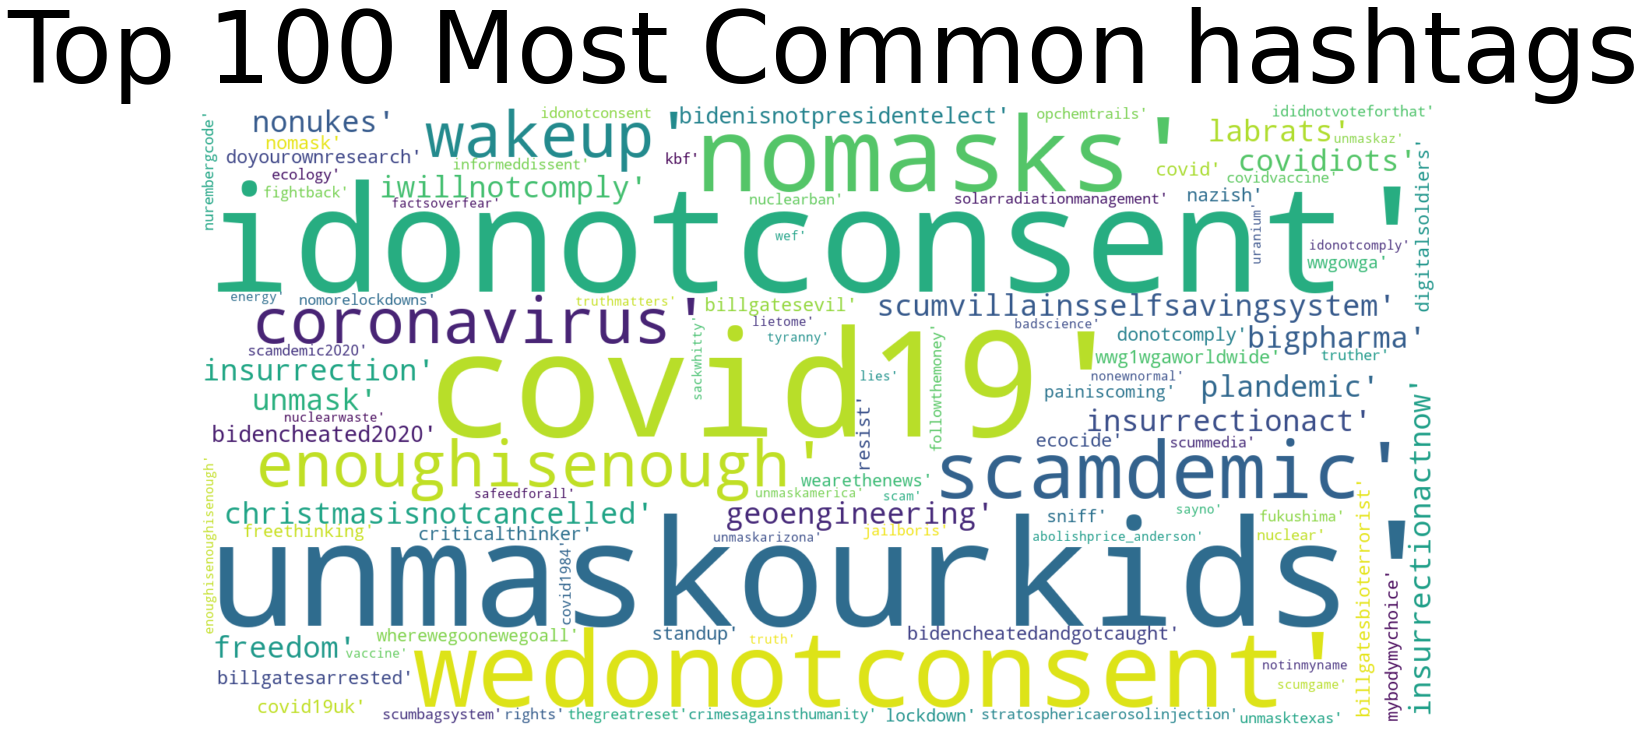

In [307]:
mostcommon = FreqDist(hashtags).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))

fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common hashtags', fontsize=100)
plt.tight_layout(pad=0)
plt.show()

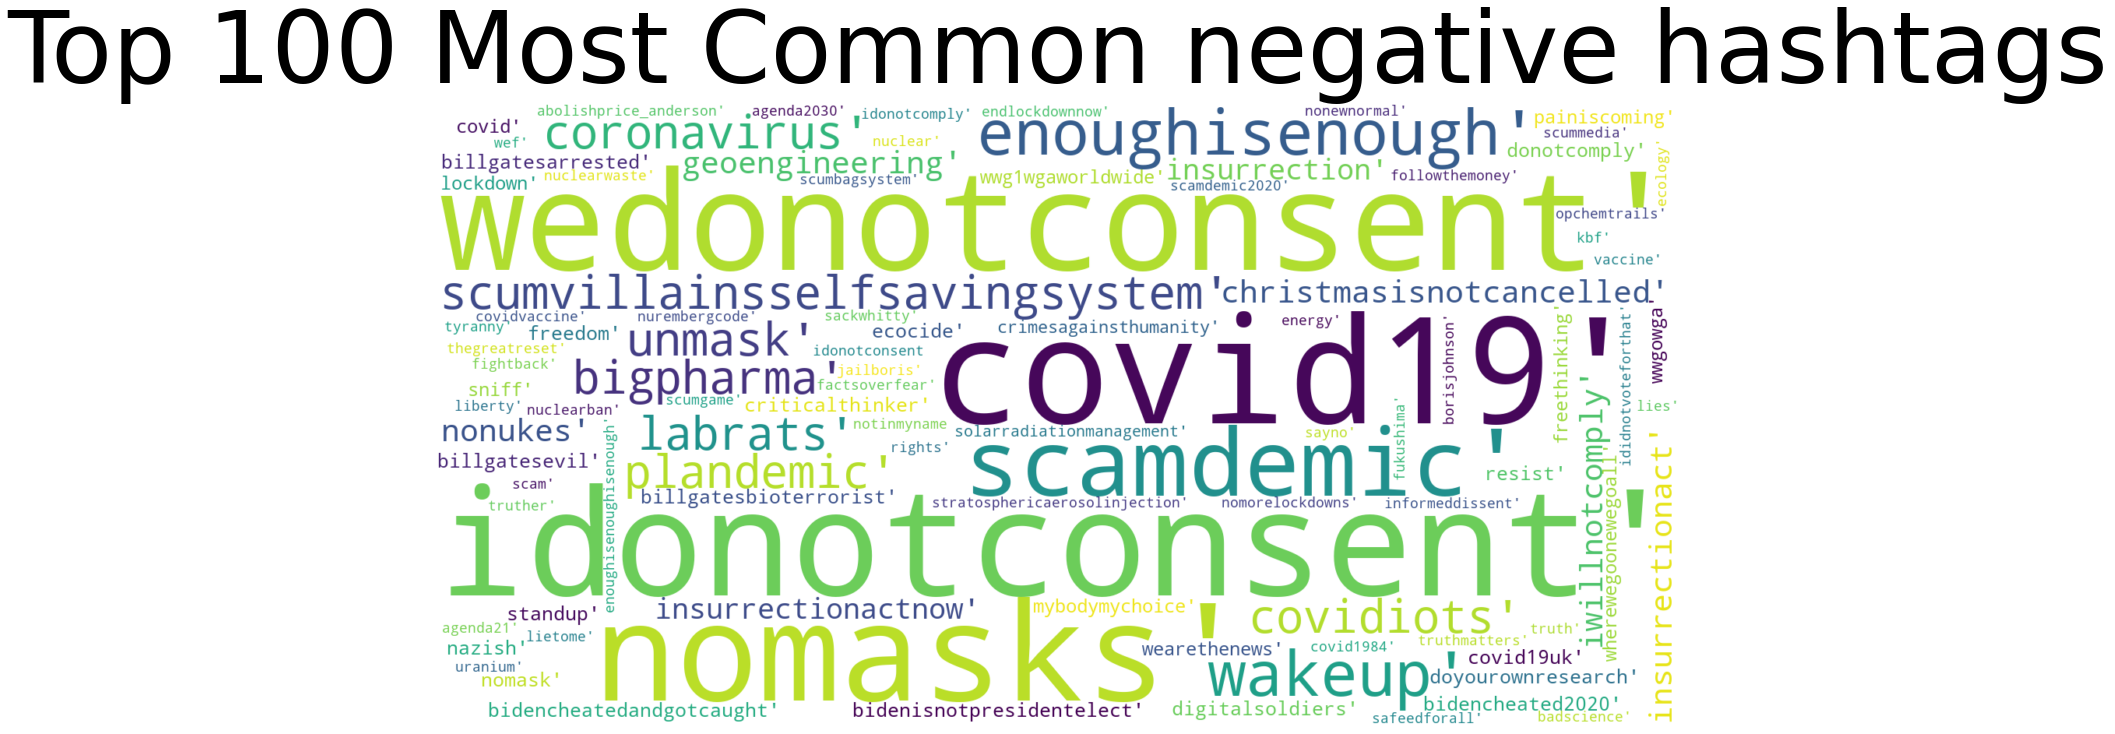

In [310]:
mostcommon = FreqDist(hashtags_neg).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))

fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common negative hashtags', fontsize=100)
plt.tight_layout(pad=0)
plt.show()

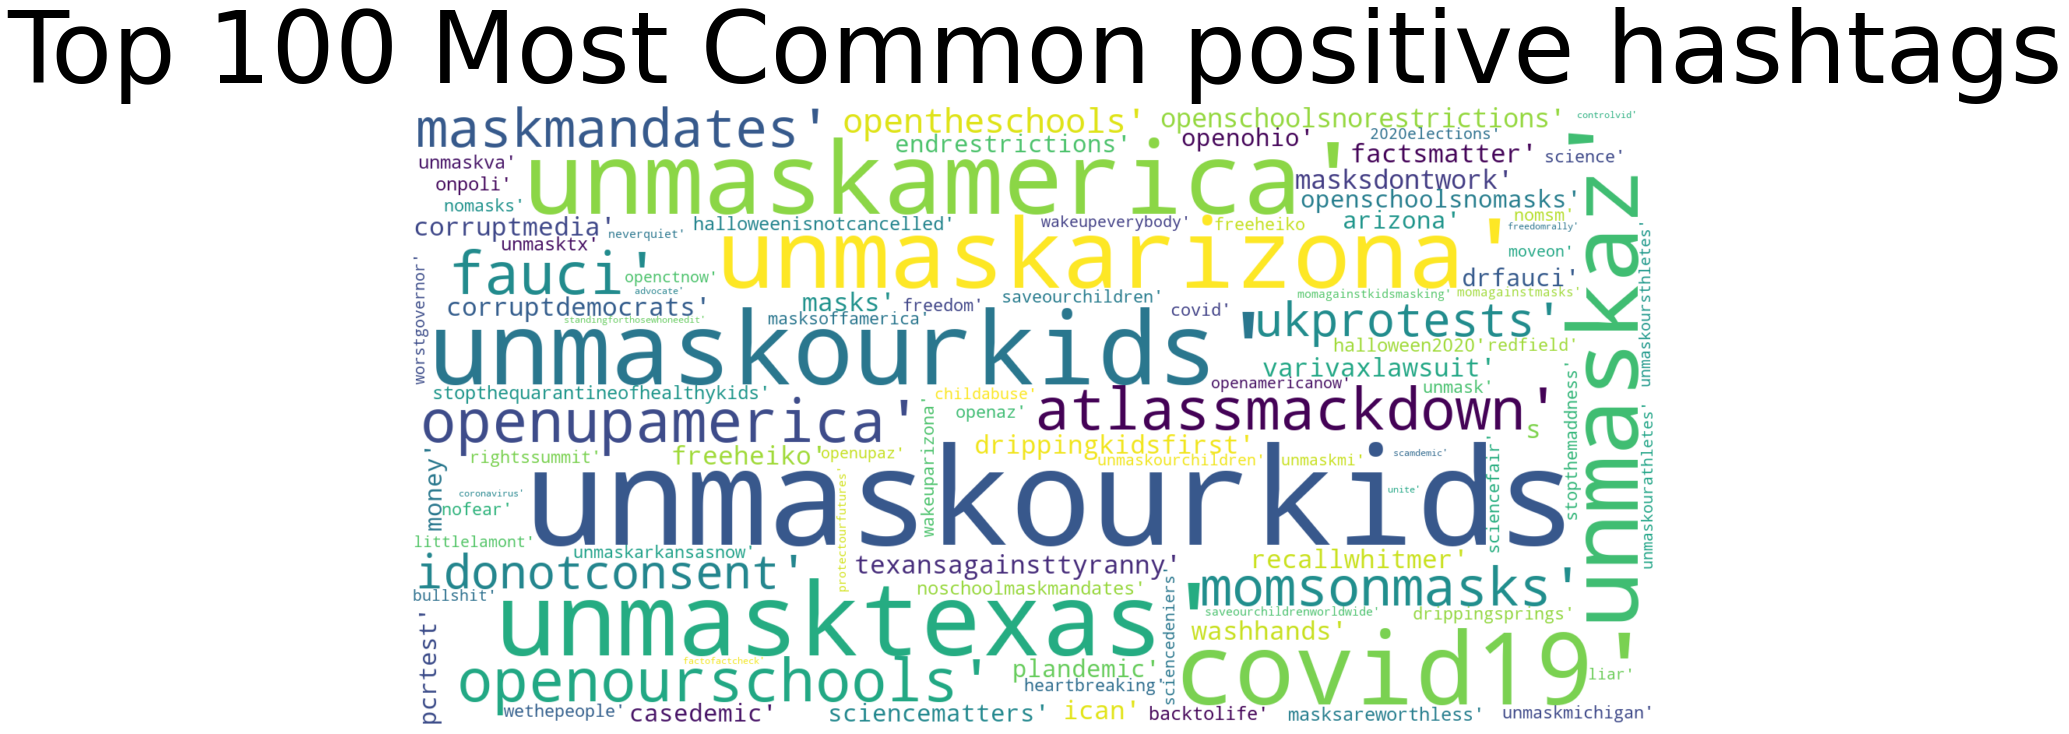

In [311]:
mostcommon = FreqDist(hashtags_pos).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))

fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common positive hashtags', fontsize=100)
plt.tight_layout(pad=0)
plt.show()

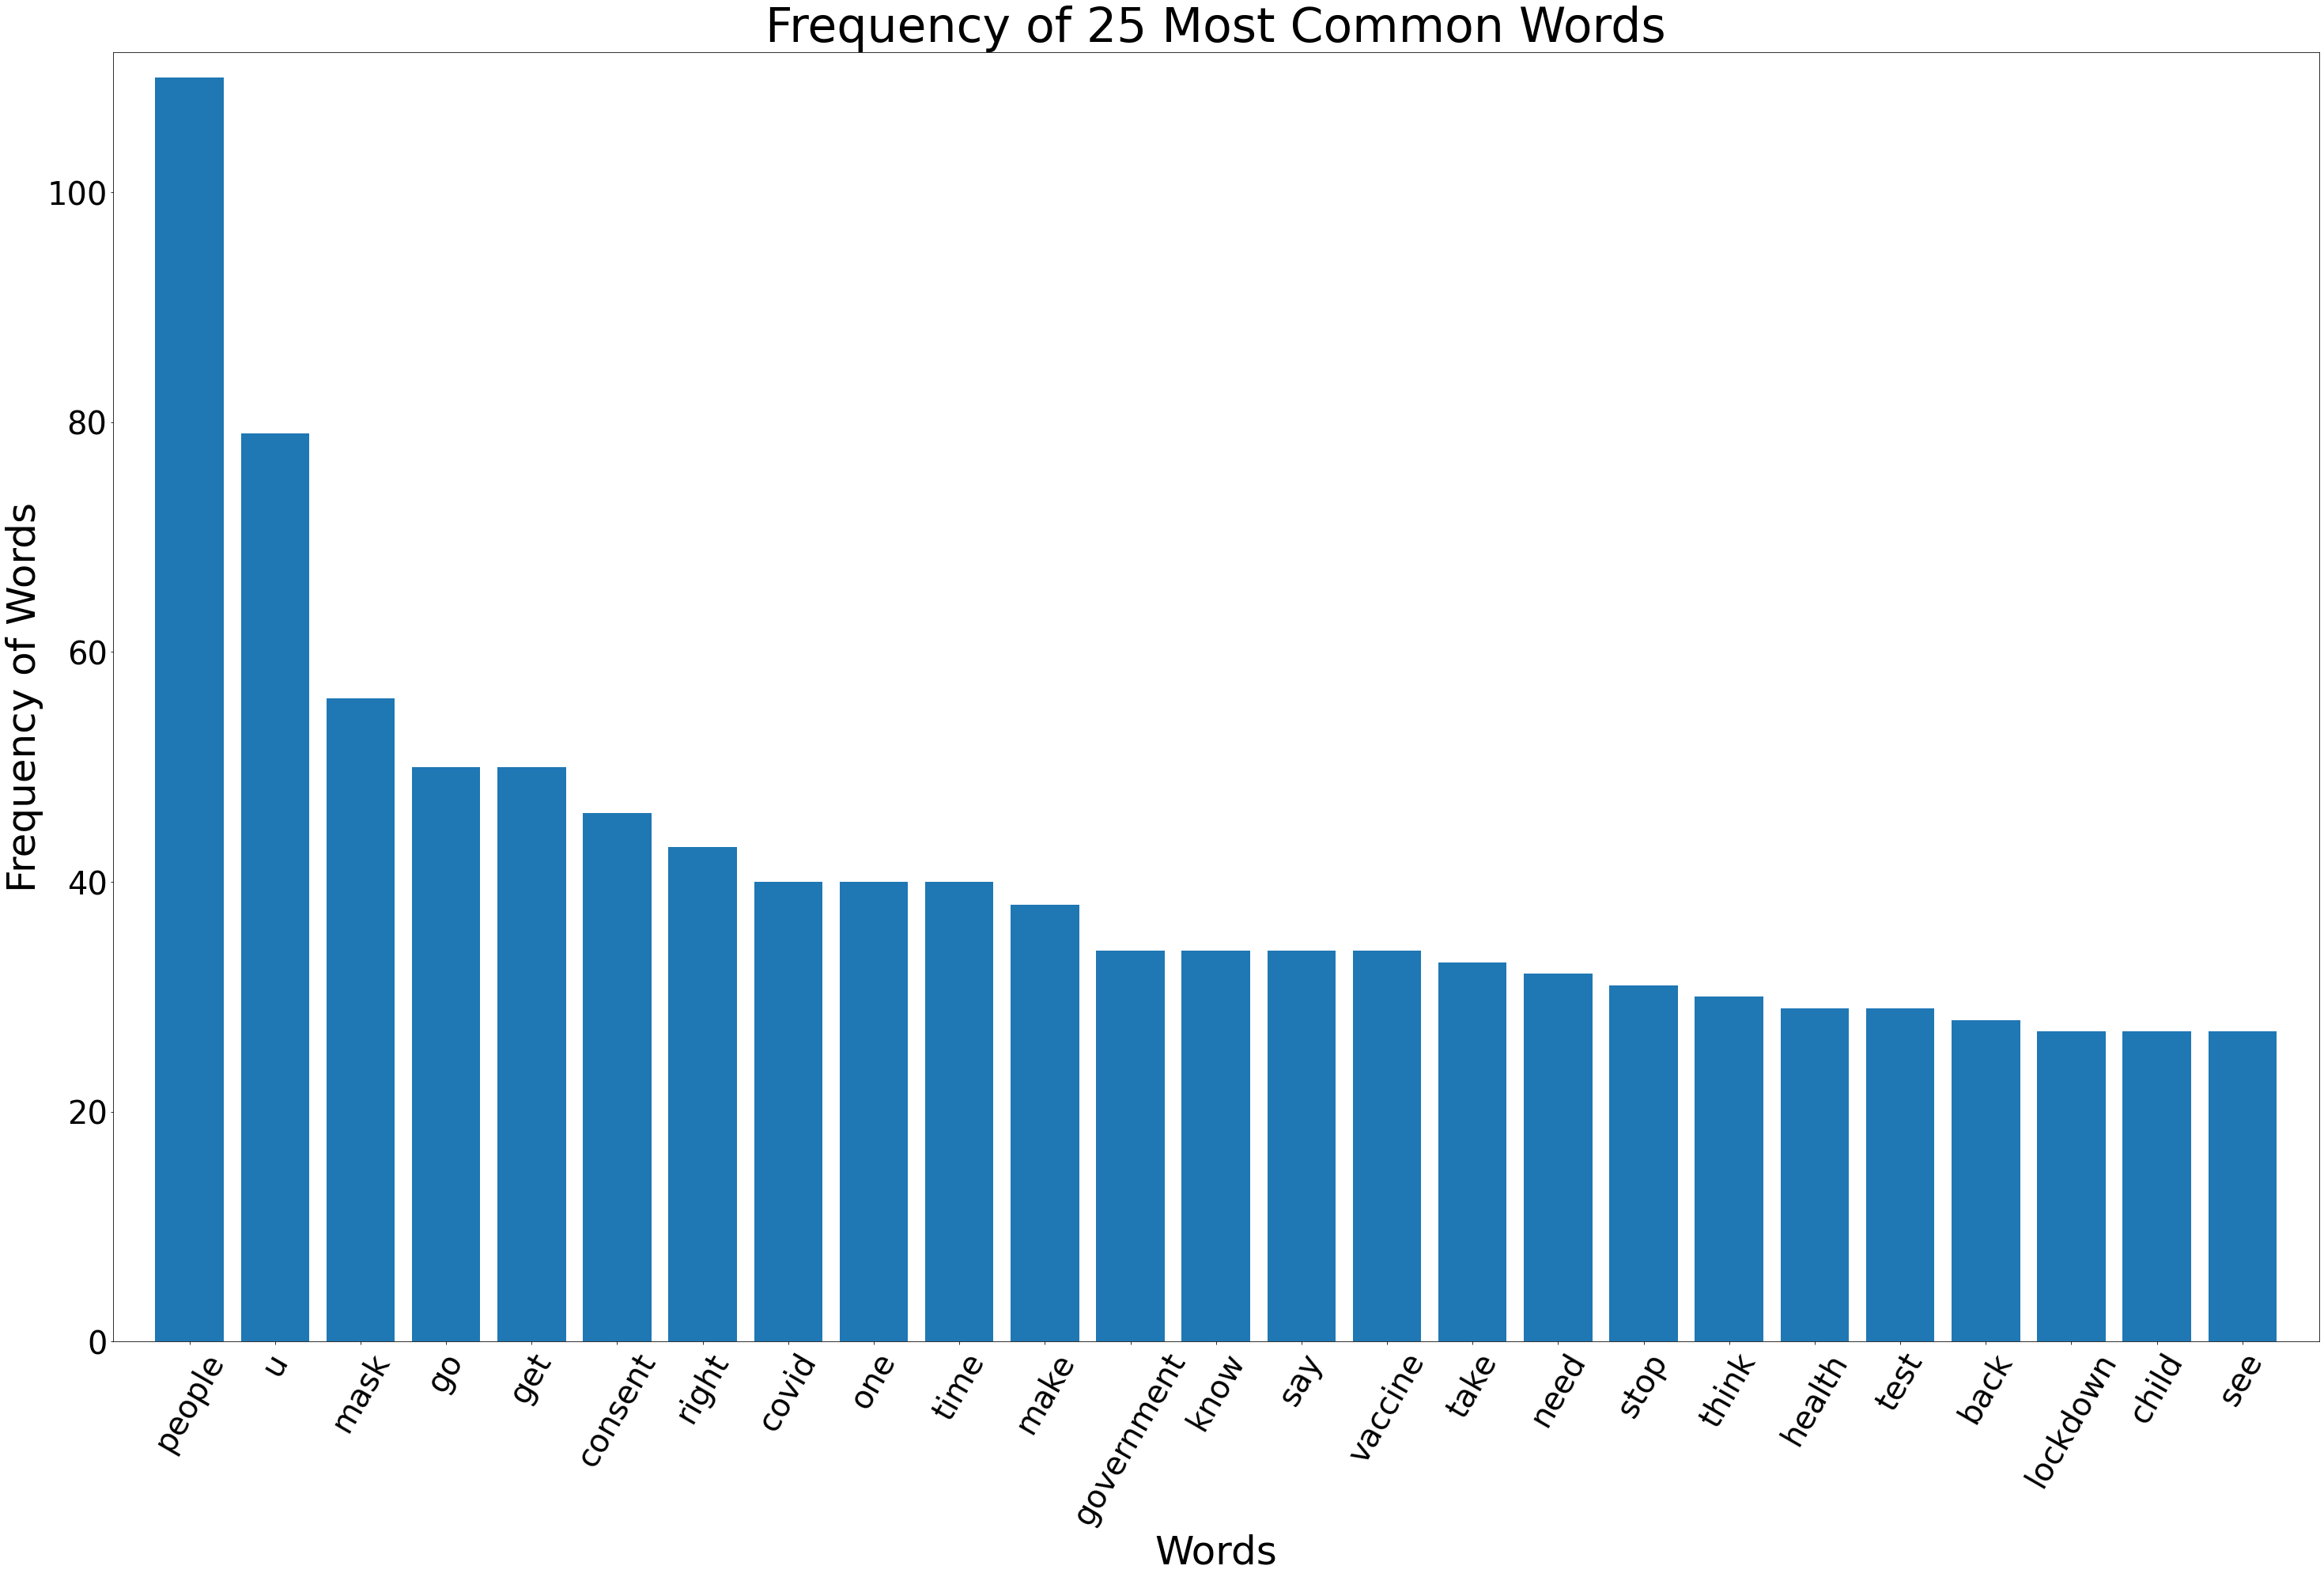

In [302]:
mostcommon_small = FreqDist(allwords).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words', fontsize=60)
plt.show()

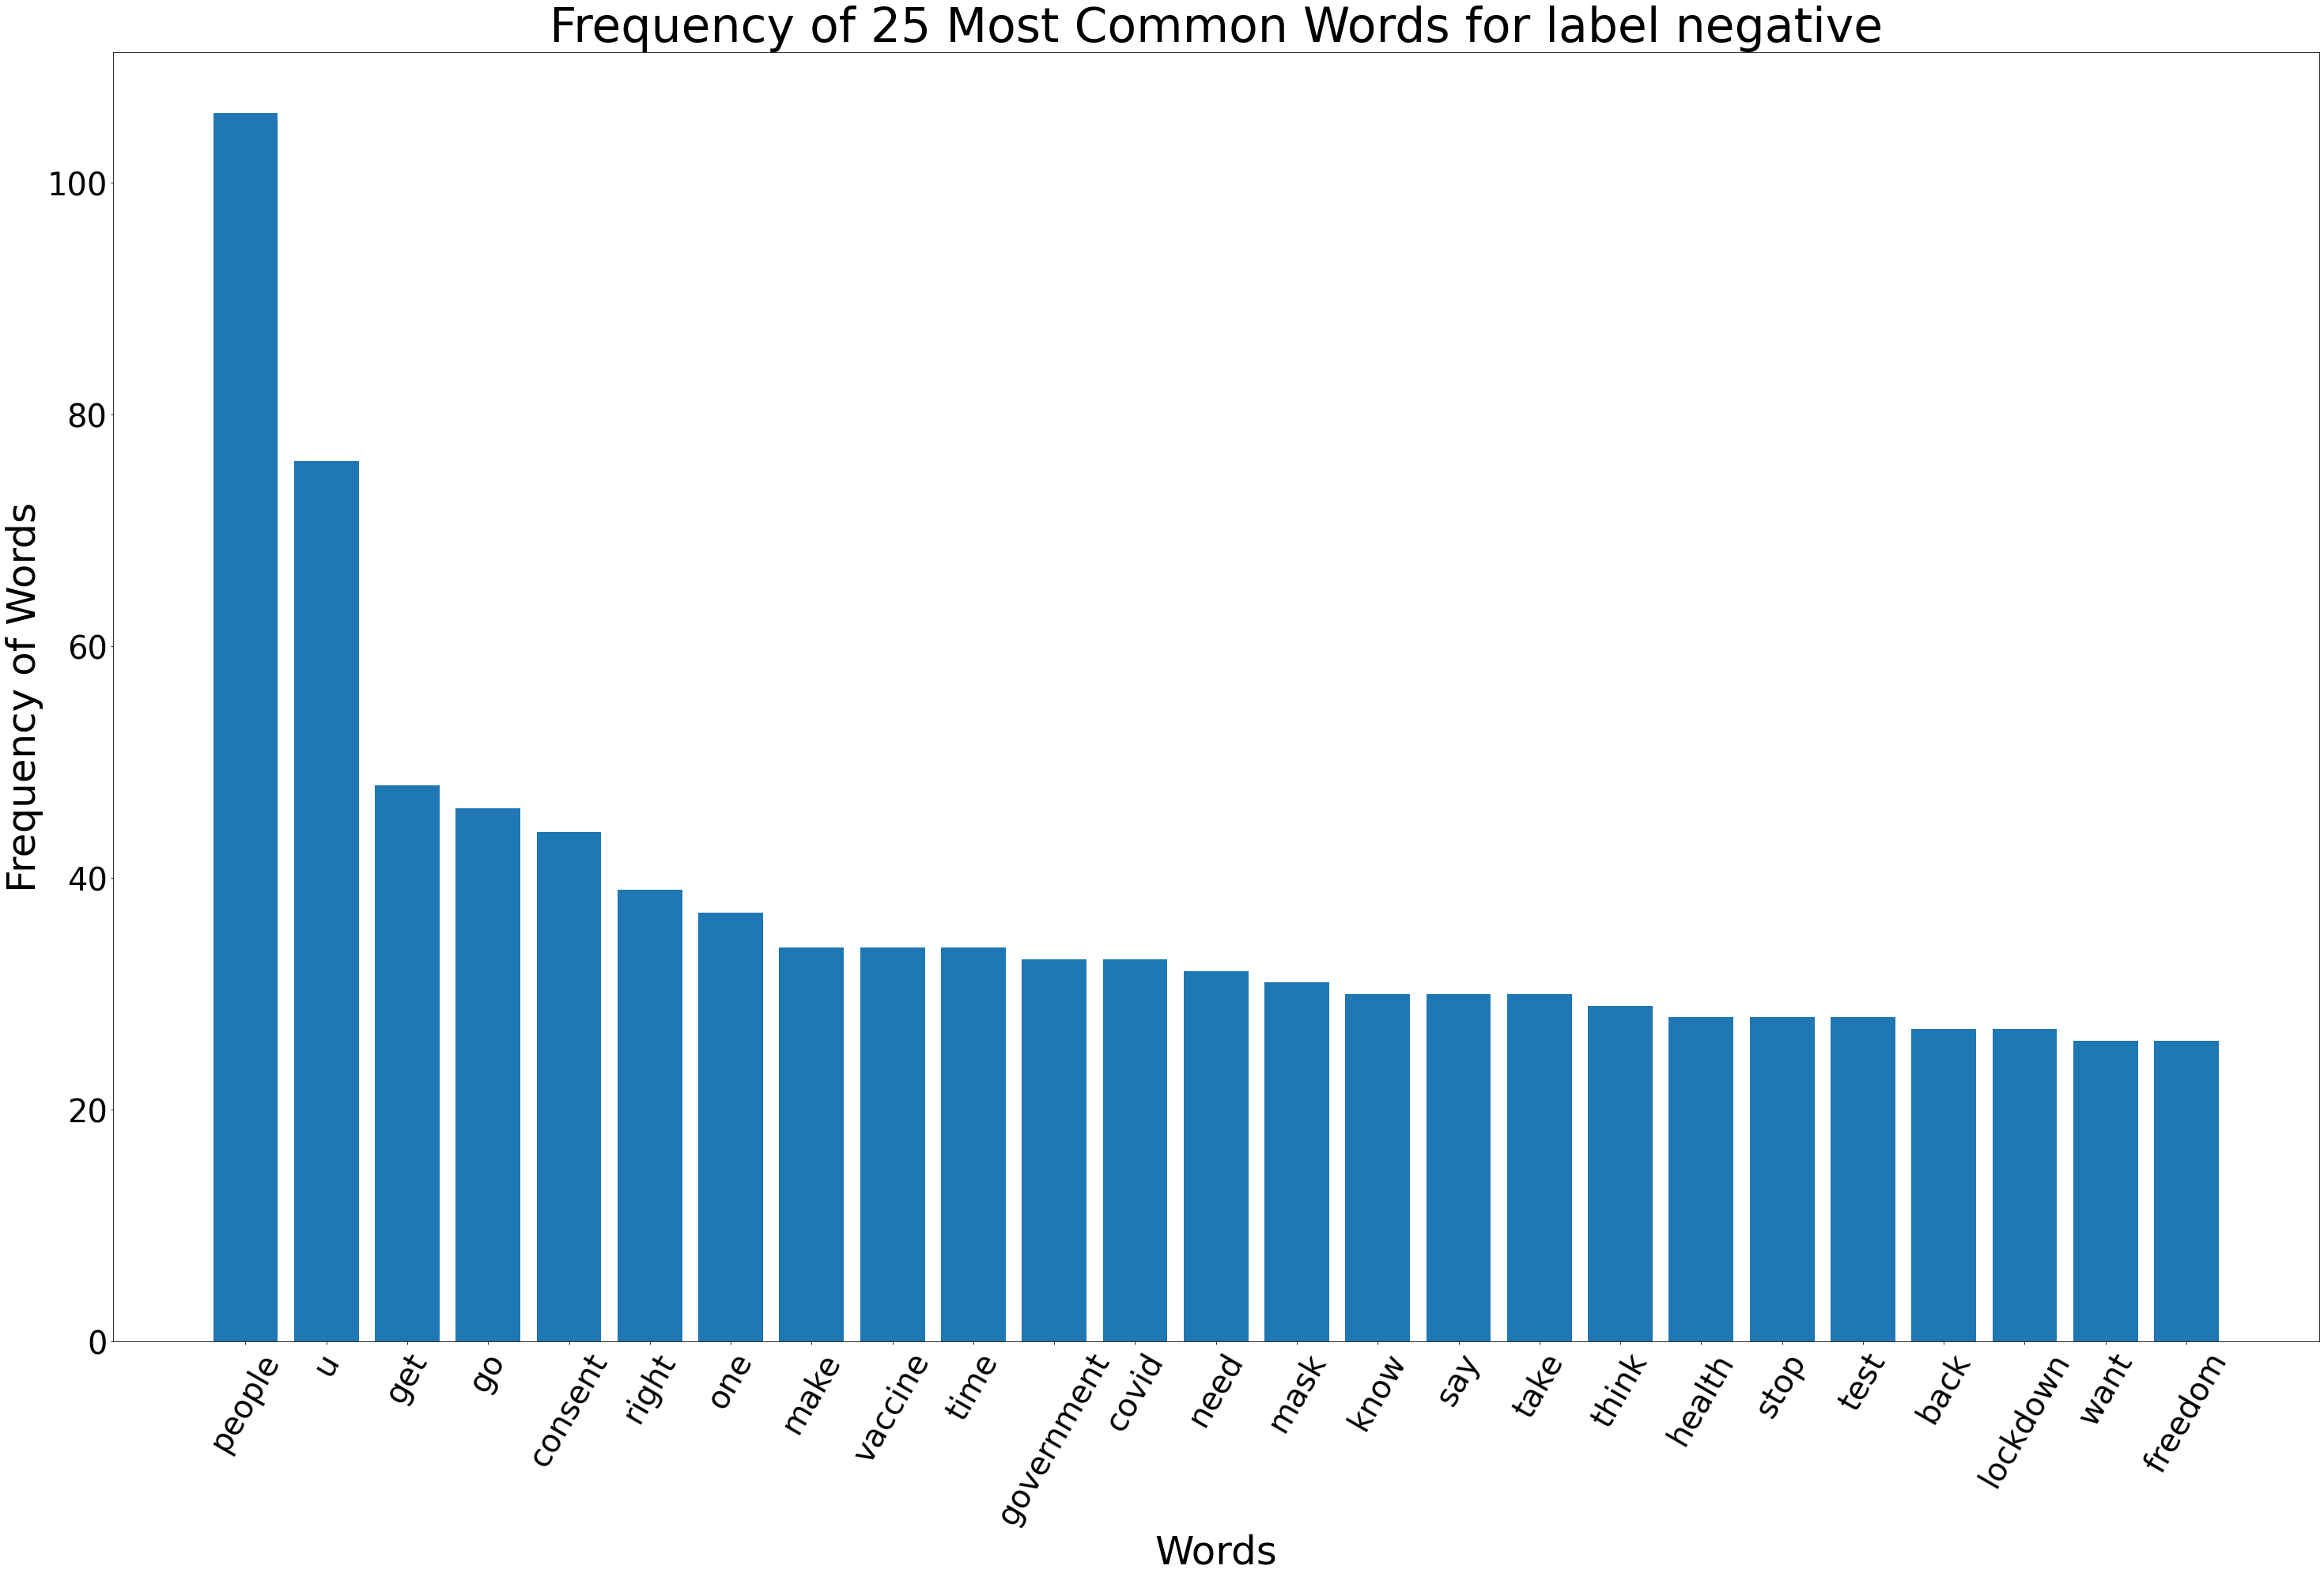

In [303]:
mostcommon_neg = FreqDist(allwords_neg).most_common(25)
words0 = list(zip(*mostcommon_neg))[0]
freq0 = list(zip(*mostcommon_neg))[1]
plt.figure(figsize=(50,30))
plt.bar(words0, freq0)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for label negative', fontsize=60)
plt.show()

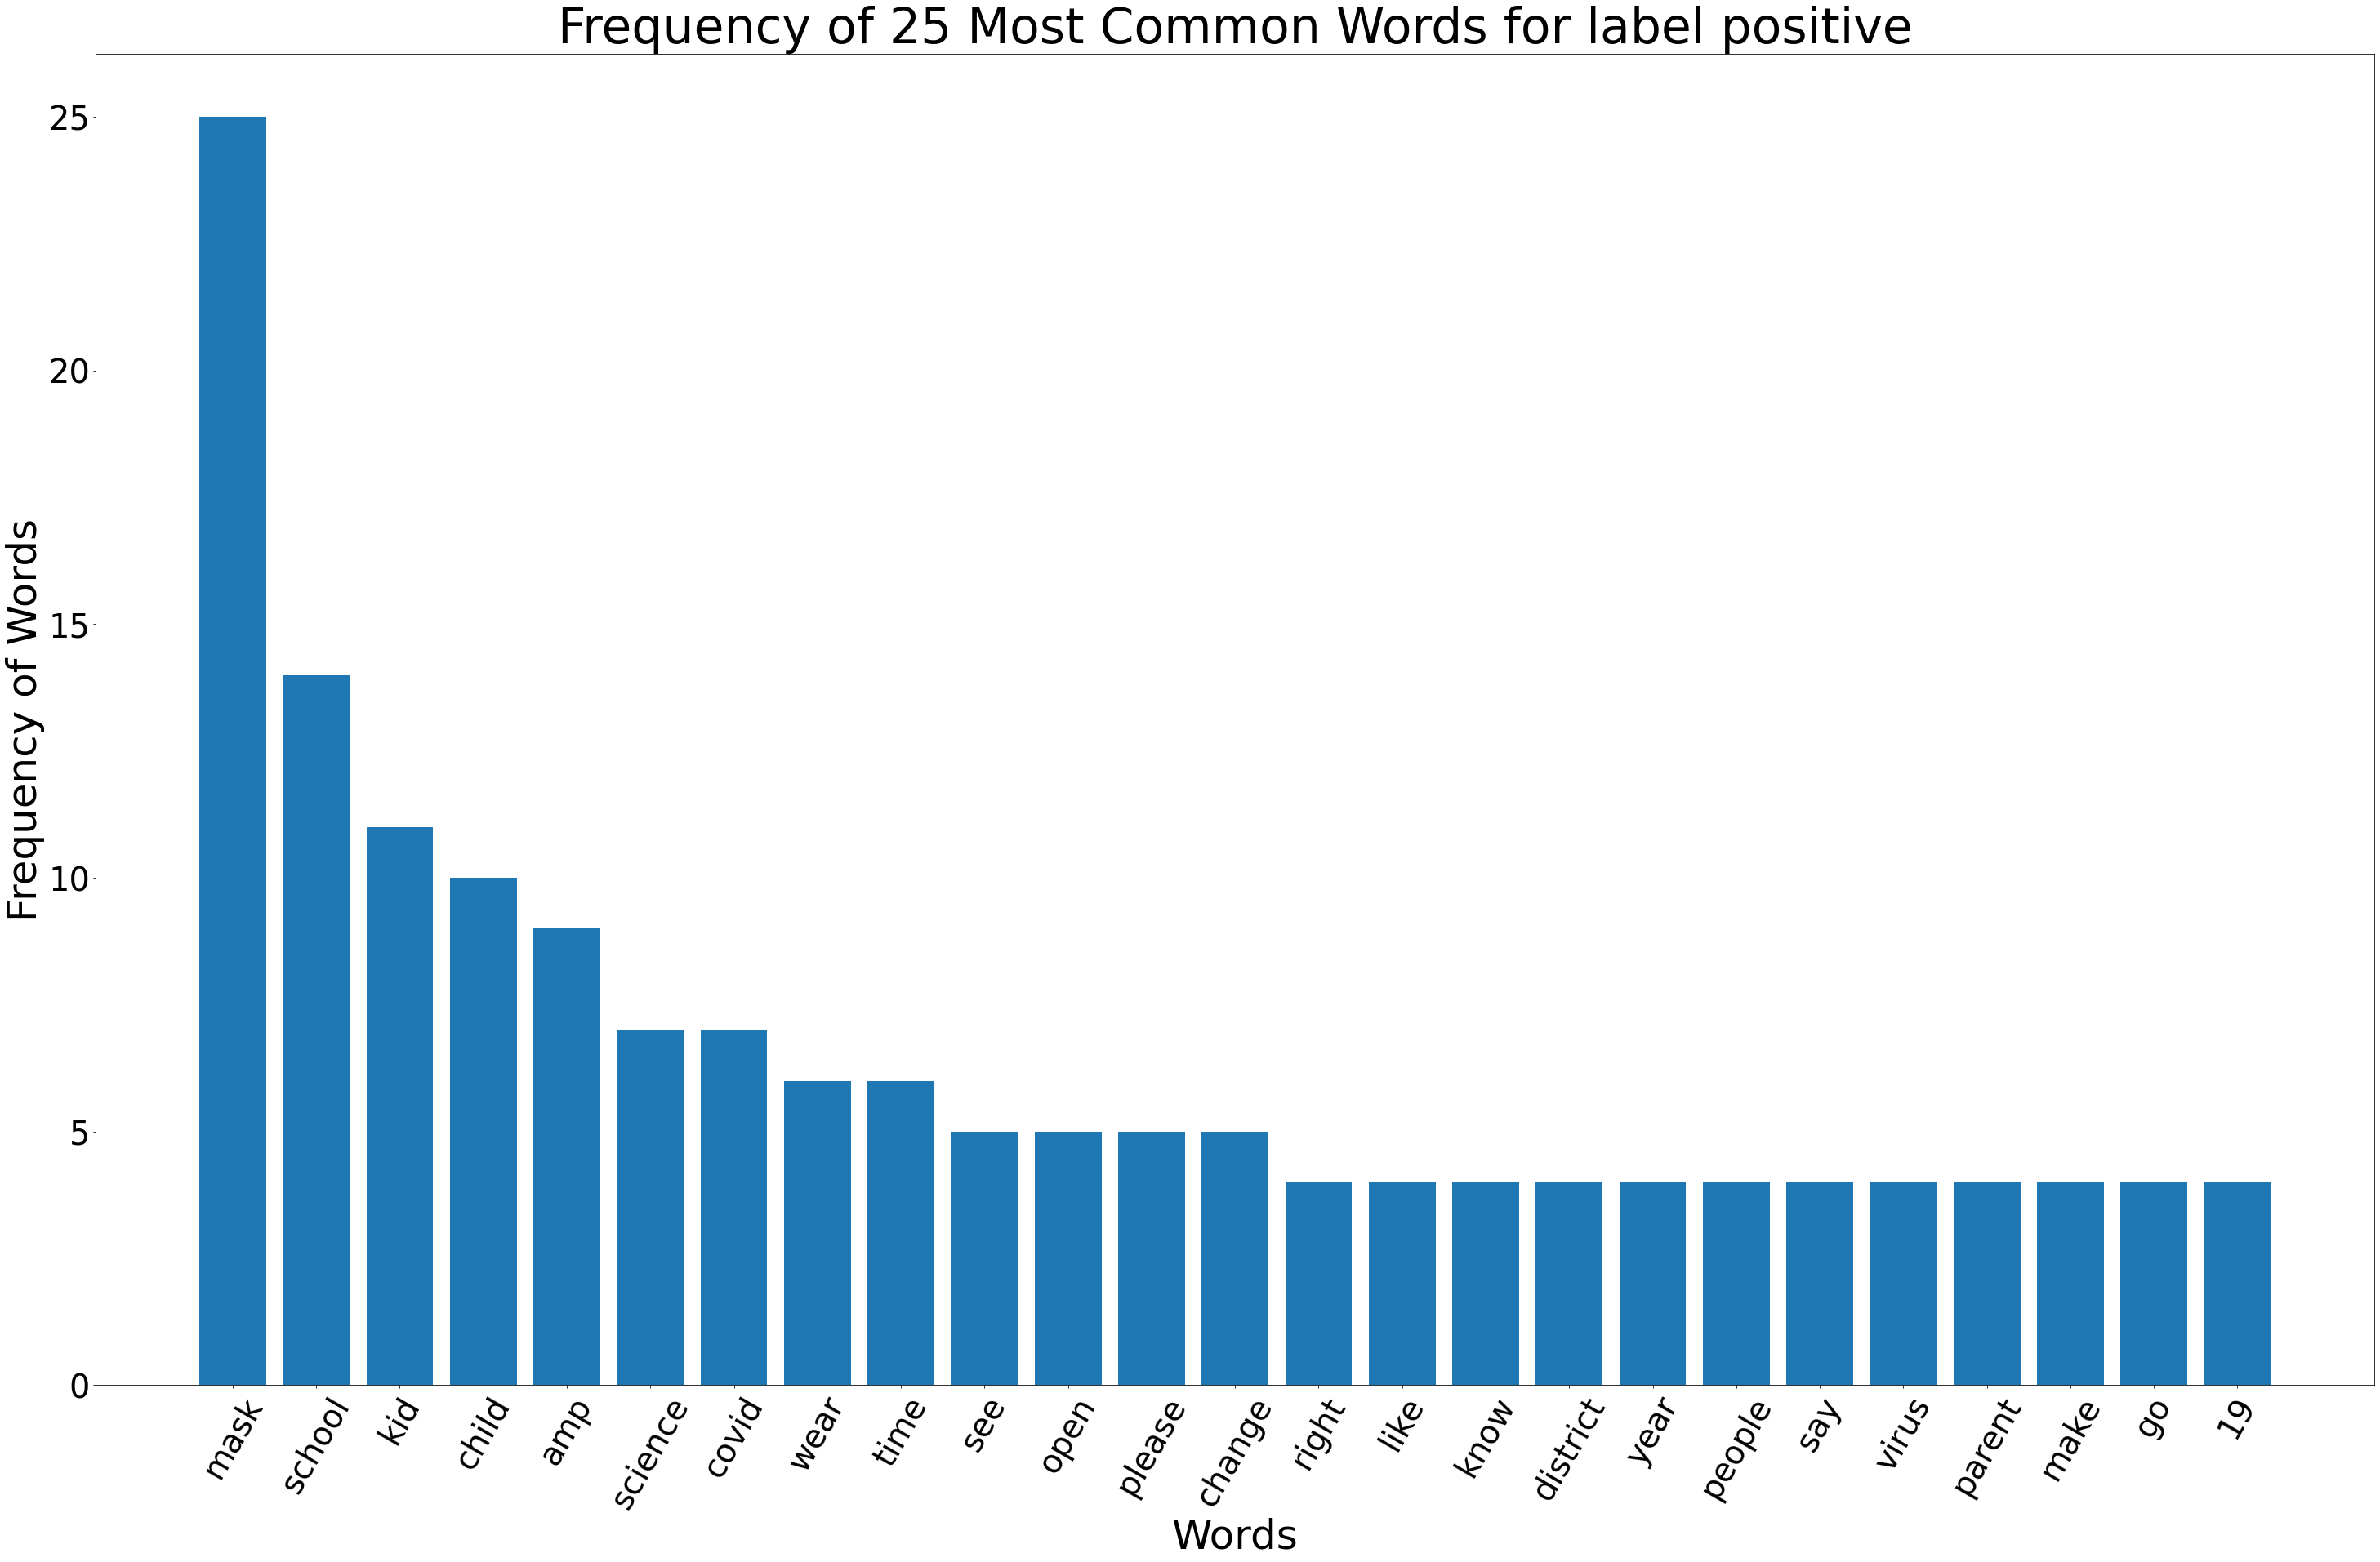

In [304]:
mostcommon_pos = FreqDist(allwords_pos).most_common(25)
words0 = list(zip(*mostcommon_pos))[0]
freq0 = list(zip(*mostcommon_pos))[1]
plt.figure(figsize=(50,30))
plt.bar(words0, freq0)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 Most Common Words for label positive', fontsize=60)
plt.show()